In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv("../dataset/train.csv")
test = pd.read_csv("../dataset/test.csv")

y = train["accident_risk"]
X = train.drop(columns=["accident_risk"]).set_index("id")
X_test = test.copy().set_index("id")

In [2]:
X.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
id,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1


### Preprocessing

In [3]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
], remainder="drop", verbose_feature_names_out=False)

### Models

In [4]:
SEED = 42
models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=12, random_state=SEED, n_jobs=-1),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=SEED,
        tree_method="hist",
        predictor="gpu_predictor",
        verbosity=0,
        use_label_encoder=False,
        device="cuda"
    )
}
pipelines = {name: Pipeline([("pre", preprocessor), ("model", model)]) for name, model in models.items()}

### CV OOF Collection

In [5]:
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof = {name: np.zeros(len(X)) for name in pipelines}
per_fold_rmse = {name: [] for name in pipelines}

print("Generating OOF preds (progress by model):")
for name, pipe in pipelines.items():
    print("\nModel:", name)
    for fold, (tr, va) in enumerate(tqdm(kf.split(X), total=N_SPLITS, desc=f"{name} folds"), start=1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        pipe.fit(X_tr, y_tr)
        p = pipe.predict(X_va)
        oof[name][va] = p
        rmse_fold = np.sqrt(mean_squared_error(y_va, p))
        per_fold_rmse[name].append(rmse_fold)
        tqdm.write(f" Fold {fold} RMSE: {rmse_fold:.6f}")

Generating OOF preds (progress by model):

Model: Ridge


Ridge folds:   0%|          | 0/5 [00:00<?, ?it/s]

 Fold 1 RMSE: 0.073531
 Fold 2 RMSE: 0.073536
 Fold 3 RMSE: 0.073630
 Fold 4 RMSE: 0.073435
 Fold 5 RMSE: 0.073364

Model: RandomForest


RandomForest folds:   0%|          | 0/5 [00:00<?, ?it/s]

 Fold 1 RMSE: 0.056469
 Fold 2 RMSE: 0.056378
 Fold 3 RMSE: 0.056422
 Fold 4 RMSE: 0.056262
 Fold 5 RMSE: 0.056144

Model: XGBoost


XGBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

 Fold 1 RMSE: 0.056351
 Fold 2 RMSE: 0.056236
 Fold 3 RMSE: 0.056249
 Fold 4 RMSE: 0.056056
 Fold 5 RMSE: 0.056053


### Stacking meta-model
Simple Ridge on OOFs

In [6]:
meta_X = np.vstack([oof[n] for n in pipelines]).T
meta_model = Ridge(alpha=1.0)
meta_oof = np.zeros(len(X))
meta_fold_rmse = []
print("\nEvaluating stacking via KFold on meta-features:")
for fold, (tr, va) in enumerate(tqdm(kf.split(meta_X), total=N_SPLITS, desc="Stacking folds"), start=1):
    meta_model.fit(meta_X[tr], y.iloc[tr])
    p = meta_model.predict(meta_X[va])
    meta_oof[va] = p
    rmse_fold = np.sqrt(mean_squared_error(y.iloc[va], p))
    meta_fold_rmse.append(rmse_fold)
    tqdm.write(f" Fold {fold} stacking RMSE: {rmse_fold:.6f}")
per_fold_rmse["Stacking"] = meta_fold_rmse
oof["Stacking"] = meta_oof


Evaluating stacking via KFold on meta-features:


Stacking folds:   0%|          | 0/5 [00:00<?, ?it/s]

 Fold 1 stacking RMSE: 0.056316
 Fold 2 stacking RMSE: 0.056203
 Fold 3 stacking RMSE: 0.056234
 Fold 4 stacking RMSE: 0.056045
 Fold 5 stacking RMSE: 0.056008


### Summary Table

In [7]:
summary = []
for name in per_fold_rmse:
    arr = np.array(per_fold_rmse[name])
    summary.append({
        "model": name,
        "mean_rmse": arr.mean(),
        "std_rmse": arr.std(ddof=1),
        "oof_rmse": np.sqrt(mean_squared_error(y.values, oof[name]))
    })
summary_df = pd.DataFrame(summary).sort_values("mean_rmse").reset_index(drop=True)
print("\nPer-model summary:")
print(summary_df)


Per-model summary:
          model  mean_rmse  std_rmse  oof_rmse
0      Stacking   0.056161  0.000130  0.056161
1       XGBoost   0.056189  0.000131  0.056189
2  RandomForest   0.056335  0.000132  0.056335
3         Ridge   0.073499  0.000103  0.073499


### Comparison
Compare Ridge vs RF and Ridge vs XGB (paired across folds)

In [8]:
def paired_test(a_name, b_name):
    a = np.array(per_fold_rmse[a_name])
    b = np.array(per_fold_rmse[b_name])
    diff = a - b
    tstat, pval = stats.ttest_rel(a, b)
    return {"pair": f"{a_name} vs {b_name}", "mean_diff": diff.mean(), "t": tstat, "p": pval}
tests = [paired_test("Ridge", "RandomForest"), paired_test("Ridge", "XGBoost"), paired_test("RandomForest", "XGBoost")]
print("\nPaired t-tests (per-fold RMSE):")
print(pd.DataFrame(tests))


Paired t-tests (per-fold RMSE):
                      pair  mean_diff           t             p
0    Ridge vs RandomForest   0.017164  614.891477  4.197104e-11
1         Ridge vs XGBoost   0.017310  472.842944  1.200247e-10
2  RandomForest vs XGBoost   0.000146    7.194166  1.978157e-03


### Visualization

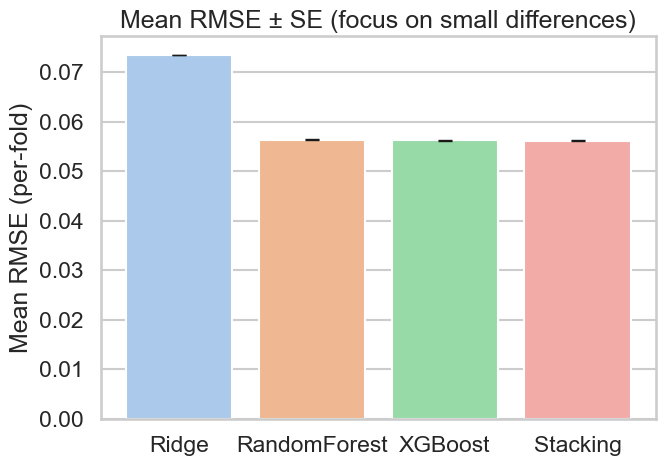

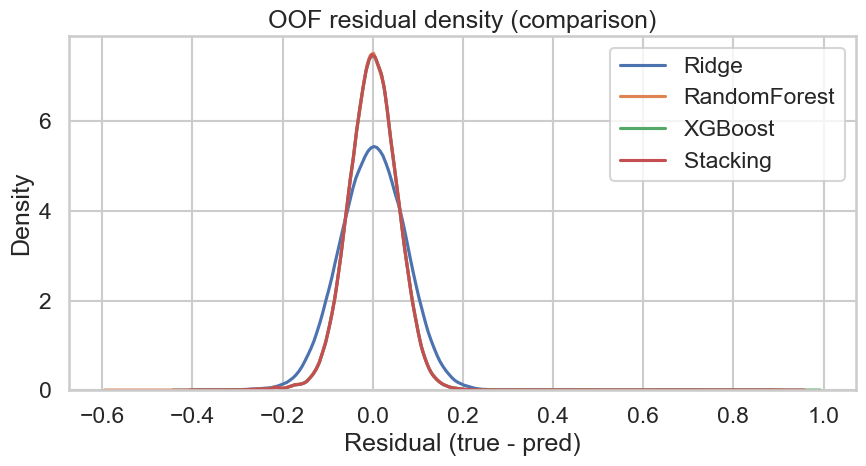

In [9]:
sns.set(style="whitegrid", context="talk")

# Mean ± SE barplot (zoomed) to show minute differences
plt.figure(figsize=(7,5))
models_for_plot = ["Ridge","RandomForest","XGBoost","Stacking"]
means = [np.mean(per_fold_rmse[m]) for m in models_for_plot]
ses = [np.std(per_fold_rmse[m], ddof=1)/np.sqrt(N_SPLITS) for m in models_for_plot]
ax = sns.barplot(x=models_for_plot, y=means, palette="pastel", capsize=0.15)
for i,(m,mean,se) in enumerate(zip(models_for_plot,means,ses)):
    ax.errorbar(i, mean, yerr=se, color="k", capsize=5)
plt.ylabel("Mean RMSE (per-fold)")
plt.title("Mean RMSE ± SE (focus on small differences)")
plt.tight_layout()
plt.show()


# Residual density comparison (OOF residuals)
plt.figure(figsize=(9,5))
for name in ["Ridge","RandomForest","XGBoost","Stacking"]:
    resid = y.values - oof[name]
    sns.kdeplot(resid, label=name, fill=False)
plt.title("OOF residual density (comparison)")
plt.xlabel("Residual (true - pred)")
plt.legend()
plt.tight_layout()
plt.show()

### Feature importance


Fitting RF and XGB on full data for feature importances...


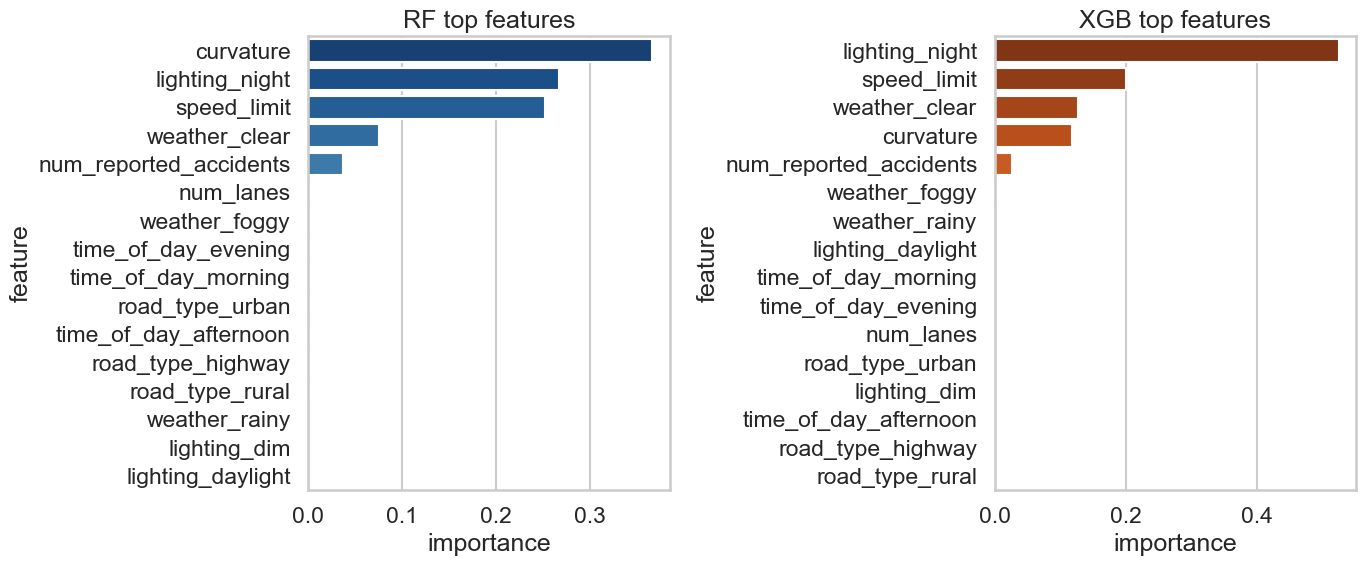

In [10]:
print("\nFitting RF and XGB on full data for feature importances...")
rf_pipe = pipelines["RandomForest"]
xgb_pipe = pipelines["XGBoost"]
rf_pipe.fit(X, y)
xgb_pipe.fit(X, y)

pre = preprocessor
pre.fit(X)
out_cols = pre.get_feature_names_out()

def get_importances(pipe, top_n=25):
    model = pipe.named_steps["model"]
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "get_booster"):
        importances = model.get_booster().get_score(importance_type="gain")
        impt = np.zeros(len(out_cols))
        for k,v in importances.items():
            if k.startswith("f"):
                idx = int(k[1:])
                if idx < len(impt):
                    impt[idx] = v
        importances = impt
    else:
        return pd.DataFrame()
    df = pd.DataFrame({"feature": out_cols, "importance": importances})
    df = df.sort_values("importance", ascending=False).head(top_n).reset_index(drop=True)
    return df

rf_imp = get_importances(rf_pipe, top_n=20)
xgb_imp = get_importances(xgb_pipe, top_n=20)

# Plot top importances
fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.barplot(x="importance", y="feature", data=rf_imp, ax=axes[0], palette="Blues_r")
axes[0].set_title("RF top features")
sns.barplot(x="importance", y="feature", data=xgb_imp, ax=axes[1], palette="Oranges_r")
axes[1].set_title("XGB top features")
plt.tight_layout()
plt.show()

### Final training and prediction

In [11]:
print("\nTraining base models on full data and producing stacked test preds...")
test_meta = []
for name, pipe in pipelines.items():
    pipe.fit(X, y)
    test_meta.append(pipe.predict(X_test))
test_meta_X = np.vstack(test_meta).T
meta_model.fit(meta_X, y.values)
test_preds = meta_model.predict(test_meta_X)

submission = pd.DataFrame({
    "id": test["id"] if "id" in test.columns else np.arange(len(test)),
    "accident_risk": test_preds
}).set_index("id")
print("\nTop rows of submission:")
print(submission.head())


print("\nFinal model summary (mean RMSE per fold):")
print(summary_df)


Training base models on full data and producing stacked test preds...

Top rows of submission:
        accident_risk
id                   
517754       0.297589
517755       0.122082
517756       0.182856
517757       0.337285
517758       0.407815

Final model summary (mean RMSE per fold):
          model  mean_rmse  std_rmse  oof_rmse
0      Stacking   0.056161  0.000130  0.056161
1       XGBoost   0.056189  0.000131  0.056189
2  RandomForest   0.056335  0.000132  0.056335
3         Ridge   0.073499  0.000103  0.073499


In [12]:
submission.to_csv("../predictions/final.csv")